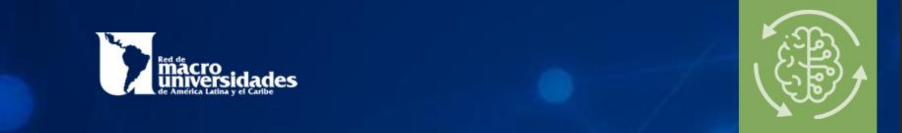

# **ESTADÍSTICA** - *LAB 2: Modelo de Clasificación*
---

MARÍA INÉS STIMOLO -
PABLO ORTIZ

Universidad Nacional de Córdoba, Argentina

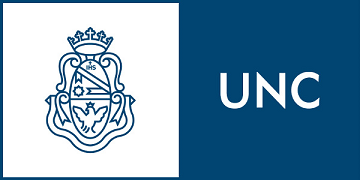


---
### Objetivo General
Implementar y evaluar modelos de clasificación en un problema concreto de clasificación binaria.

### Objetivos específicos

* Identificar y entrenar modelos adecuados en relación al tipo de variable objetivo (i.e. modelos de clasificación).
* Aplicar métodos de remuestreo (*cross-validation*) en el proceso de evaluación de los modelos ajustados.
* Utilizar métricas adecuadas para evaluar los distntos modelos empleados y compararlos con un modelo de referencia (*baseline*).
* Evaluar y seleccionar de forma sistemática los hiperparámetros adecuados para los modelos.

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

#!pip install plotly==5.3.1
import plotly.express as px

# Descripción del dataset

### Contexto
El departamento de crédito al consumo de un banco quiere automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito con garantía hipotecaria. Así, se busca construir un modelo ue permita predecir si un cliente entraría eventualmente de *default* (incumplirá el pago del crédito) en base a datos recogidos de solicitantes recientes a los que se les ha concedido un crédito a través del proceso actual de suscripción.




### Variables

| Nombre      | Descripción |
| ----------- | ----------- |
| **TARGET**  | 1: cliente con crédito en defalut/no pago - 0: préstamos repagado |
| **LOAN**    | Monto del préstamo requerido |
| **MORTDUE** | Importe adeudado sobre hipoteca existente |
| **VALUE**   | Valor de la propiedad |
| **YOJ**     | Antigüedad (años) en el trabajo actual |
| **DEROG**   | Número de informes derogatorios relevantes |
| **DELINQ**  | Número de líneas de créditos morosas |
| **CLAGE**   | Antigüedad (en meses) de la línea comercial más antigua |
| **NINQ**    | Número de líneas de crédito recientes |
| **CLNO**    | Número de líneas de crédito |
| **DEBTINC** | Ratio deuda-ingresos |

In [ ]:
# Leemos el dataset
path = 'https://raw.githubusercontent.com/pabort/MacroEntrenam2023Estadistica/main/loan_data.csv'
df = pd.read_csv(path)

Como vemos a continuación, el dataset está muy desbalanceado: pocos ejemplos de a clase 1.

In [ ]:
from collections import Counter
# Resumen de la distribución de clases en a variable TARGET
target = df.TARGET
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Clase=%d, Frecuencia=%d, Porcentaje=%.3f%%' % (k, v, per))

Clase=0, Frecuencia=1545, Porcentaje=83.333%
Clase=1, Frecuencia=309, Porcentaje=16.667%


Haremos el split con los conjuntos de entrenamiento y test manteniendo la misma proporción de clases en (0 y 1) en los datasets.

In [ ]:
# División entre variables predictoras y predichas
X, y = df.iloc[:, 1:], df.TARGET

# división del dataser en conjuntos de entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234,
                                                    stratify=y)



#### Actividad
Realizar un análisis exploratorio sobre el dataset para analizar la relación entre los atributos y la variable objetivo (`TARGET`)

In [ ]:
# TODO

# Modelos de predicción

* Evaluaremos los modelos empleando validación cruzada de K iteraciones (*K-fold cross-validation*). En general se utiliza $K=10$ (o $5$). [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
* A efectos de asegurarnos de que en cada iteración o pliegue conservemos la misma porporción de clases que en el dataset completo, el proceso de selección será **Estratificado**.
* Además **repetido**, repitiendo cada repetición $n$ veces (cada una con diferente *randomización*). [RepeatedStratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html)
   * Se repite *K-Fold* n veces, produciendo diferentes splits en cada repetición.





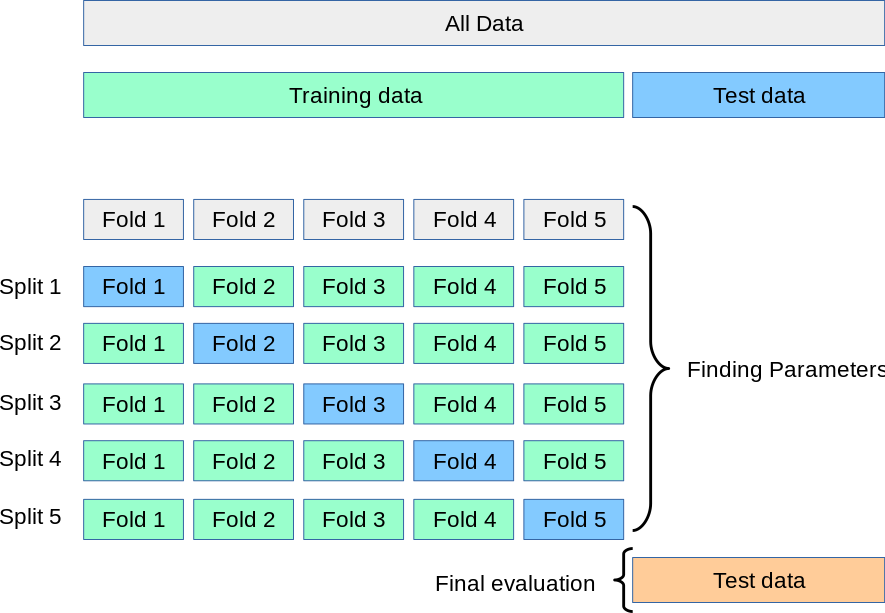

In [ ]:
# Setup: librería que usaremos
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, precision_score, recall_score  # métricas para evaluar
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier                      # nos permitirá generar una regla de clasificación trivial
from numpy import mean, std

### Modelo naif

Emplearemos un modelo trivial de referencia (*baseline*) para contrastar las predicciones realizadas test de los modelos a probar.

Una opción para esto es emplear la función [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) de sklearn, que permite hacer clasificaciones para predicciones a partir de reglas simples.

* En el proceso de clasificación, consideraremos que es más costoso clasificar como un cliente incumplidor ("defaulteador") como un buen cliente (label = 0). Los falsos negativos son más costosos
* Por lo anterior, tomaremos como criterio un modelo que minimece los `Falsos Negativos`, lo que implica maximizar el `Recall`.

In [ ]:
# Definmos el modelo de referencia clasificando todos los ejemplos con la clase 1.
model_bl = DummyClassifier(strategy='constant', constant=1)

### Métricas

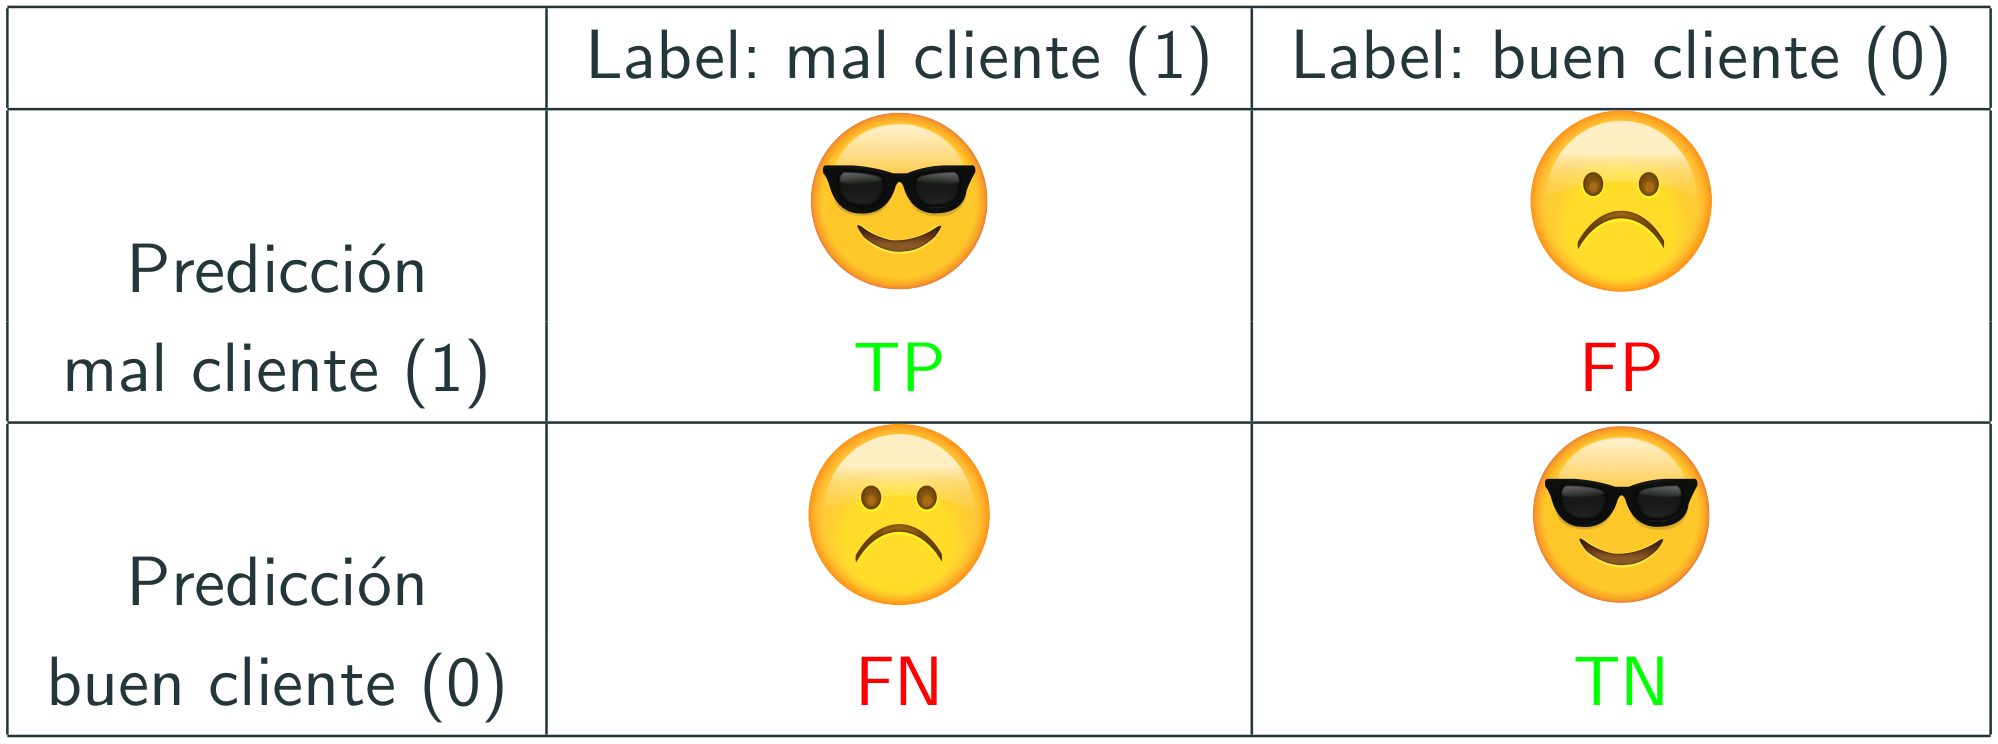

**Accuracy (exactitud)**
$$Acc = \dfrac{TP + TN}{TP + FP + TN + FN}$$

**Precisión**
$$Prec = \dfrac{TP}{TP + FP}$$

**Recall (sensitividad)**
$$Recall = \dfrac{TP}{TP + FN}$$

**F beta**
$$F_{\beta} = (1+\beta^2) \dfrac{Prec \cdot Recall}{\beta^2 \cdot Prec + Recall}$$

* $\beta =1/2  \Rightarrow F_{1/2}$. Mayor peso a la Precisión que al Recall.
* $\beta =1  \Rightarrow F_{1} \mbox{ score}$. (media armónica de Reccall y Pecisión)
* $\beta =2  \Rightarrow F_{2}$. Mayor peso al Recall que a la Precisión.

¿Cuál de las tres opciones sería conveniente utilizar?


A continuación se define una función que permite incorporar todos los elementos señalados en el procesos para evaluar los modelos que entrenemos.

In [ ]:
# Definimos el score F2 (También se pueden incorporar algunos score de manera directa: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
def f2_score(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model):
	# Definimos el tipo de conformación de los pliegues (fold/interaciones)
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
	# Definimos la métrica de evaluación del modelo
	metric = make_scorer(f2_score)
	# Evaluación del modelo
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return mean(scores), std(scores)

In [ ]:
scores = evaluate_model(X_train, y_train, model_bl)
print('Media F2: %.3f (%.3f)' % scores)

Media F2: 0.500 (0.005)


**Matriz de Confusión**

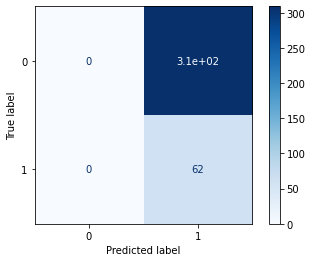

In [ ]:
from sklearn.metrics import plot_confusion_matrix
model_bl.fit(X_train, y_train)
y_pred = model_bl.predict(X_test)
plot_confusion_matrix(estimator=model_bl, X=X_test, y_true=y_test,
                      cmap='Blues')


In [ ]:
# Calculamos otras métricas de interés

a1 = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test, y_pred)
f2 = f2_score(y_test, y_pred)
p1 = precision_score(y_test, y_pred)
r1 = recall_score(y_test, y_pred)
print("accuracy score: %.3f" % a1)
print("f1 score: %.3f" % f1)
print("f2 score: %.3f" % f2)
print("precision score: %.3f" % p1)
print("recall score: %.3f" % r1)

accuracy score: 0.167
f1 score: 0.286
f2 score: 0.501
precision score: 0.167
recall score: 1.000


In [ ]:
# ToDo: Probar con otras Métricas (accuracy, pecision, recall, f1)

def evaluate_model(X, y, model):
	# Definimos el tipo de conformación de los pliegues (fold/interaciones)
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# Definimos la métrica de evaluación del modelo
	metric = make_scorer(accuracy_score) #()
	# Evaluación del modelo
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return mean(scores), std(scores)


## Modelo de regresión logística

Entrenar y evaluar un modelo de regresión logística ([LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)):

* Utilizando los valores por defecto de scikit-learn para todos los hiperparámetros.
* Cambiar los siguientes hiperparámetros (que son argumentos de la función utilizada) y analizar los cambios en la métrica de evaluación utilizada:
   * *penalty*
   * *C* (inversa del factor de regularización). Puede probar con alguno/s de los siguientes valores: [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
   * *solver* (probar por ejemplo)
* Como el dataset está muy desbalanceado, podríamos cambiar el argumento `class_weight` por `balanced`. ¿Que sucedió con las métricas utilizadas?

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# MODELO CON HIPERPARÁMETROS POD DEFECTO

model_LR = LogisticRegression()

scores = evaluate_model(X_train, y_train, model_LR)
print('Media F2: %.3f (%.3f)' % scores)


Media F2: 0.070 (0.053)


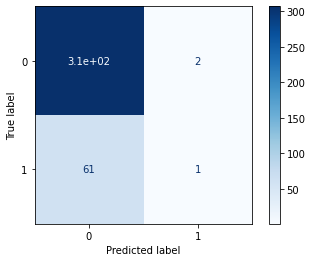

In [ ]:
from sklearn.metrics import plot_confusion_matrix
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)
plot_confusion_matrix(estimator=model_LR, X=X_test, y_true=y_test,
                      cmap='Blues')


In [ ]:
# Calculamos otras métricas de interés

a1 = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test, y_pred)
f2 = f2_score(y_test, y_pred)
p1 = precision_score(y_test, y_pred)
r1 = recall_score(y_test, y_pred)
print("accuracy score: %.3f" % a1)
print("f1 score: %.3f" % f1)
print("f2 score: %.3f" % f2)
print("precision score: %.3f" % p1)
print("recall score: %.3f" % r1)

accuracy score: 0.830
f1 score: 0.031
f2 score: 0.020
precision score: 0.333
recall score: 0.016


In [ ]:
# MODELO ALTERANDO HIPERPARÁMETROS

model_LR = LogisticRegression(penalty='l1', C=10, solver='liblinear')

scores = evaluate_model(X_train, y_train, model_LR)
print('Media F2: %.3f (%.3f)' % scores)



Media F2: 0.395 (0.099)


In [ ]:
# MODELO INCORPORANDO PESO DE LAS CLASES

model_LR = LogisticRegression(penalty='l1', C=10, solver='liblinear', class_weight = 'balanced')

scores = evaluate_model(X_train, y_train, model_LR)
print('Media F2: %.3f (%.3f)' % scores)

Media F2: 0.573 (0.062)


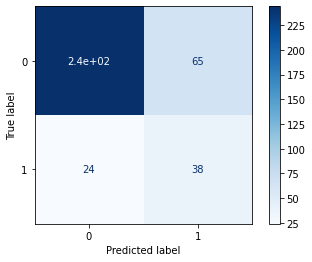

In [ ]:
from sklearn.metrics import plot_confusion_matrix
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)
plot_confusion_matrix(estimator=model_LR, X=X_test, y_true=y_test,
                      cmap='Blues')

## Tuneando hiperparámetros con [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Mediante Grid Search se pueden evaluar diferentes combinaciones de todos los hiperparámetros especificados y sus valores, calculando la performance del modelo para cada combinación seleccionando *los mejores valores para esos hiperparámetros*. Esto se verá en los próximos contenidos del curso.